# 1. Prepare necesary libraries

In [4]:
import pandas  as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime as dt 
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


import warnings

warnings.filterwarnings("ignore")

# 2. Loading data and cleaning

In [79]:
traffic = pd.read_csv('traffic_train.csv')

traffic.head()

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
0,2014-10-01 00:00:00,Clear,sky is clear,1,11.5,0.0,0.0,508
1,2014-10-01 01:00:00,Clear,sky is clear,1,10.3,0.0,0.0,323
2,2014-10-01 02:00:00,Clear,sky is clear,1,8.0,0.0,0.0,274
3,2014-10-01 03:00:00,Clear,sky is clear,1,7.9,0.0,0.0,372
4,2014-10-01 04:00:00,Clear,sky is clear,1,6.4,0.0,0.0,812


In [6]:
def dayFromDate(traffic):
    traffic['date_time'] = pd.to_datetime(traffic['date_time'])
    traffic['hour'] = traffic.date_time.dt.hour
    traffic['hour_interval'] = pd.cut(traffic.hour, bins = [-1,6,12,18,24], labels = ['0-6','6-12', '12-18', '18-24'])
    
    
    traffic['day'] = traffic.date_time.dt.day_of_week  
    
    traffic['month'] = traffic.date_time.dt.month

    traffic['tmp'] = range(0,len(traffic.hour))
    traffic['year'] = traffic.date_time.dt.year
    t1 = pd.get_dummies(traffic['month'])
    t1['tmp'] = range(0,len(traffic.month))
    traffic = pd.merge(traffic, t1, on = ['tmp'])

    t1 = pd.get_dummies(traffic['hour_interval'])
    t1['tmp'] = range(0,len(traffic.hour))
    traffic = pd.merge(traffic, t1, on = ['tmp'])

    t1 = pd.get_dummies(traffic['hour'])
    t1['tmp'] = range(0,len(traffic.hour))
    traffic = pd.merge(traffic, t1, on = ['tmp'])

    t1 = pd.get_dummies(traffic['day'])
    t1['tmp'] = range(0,len(traffic.hour))
    traffic = pd.merge(traffic, t1, on = ['tmp']).drop(columns = ['tmp'])
    return(traffic)

def ordinal_whether(traffic):
    traffic['ordinal_weather'] = np.where(traffic.weather_detailed.isin(['fog', 'freezing rain', 'heavy intensity rain','heavy snow','proximity thunderstorm',
                                 'proximity thunderstorm with drizzle', 'proximity thunderstorm with rain', 'sleet', 'squalls',
                                 'thunderstorm', 'thunderstorm with drizzle', 'thunderstorm with heavy rain', 'thunderstorm with light drizzle',
                                  'thunderstorm with light rain', 'thunderstorm with rain', 'very heavy rain']), 0, #fatalne
                                 np.where(traffic.weather_detailed.isin(['drizzle','haze', 'heavy intensity drizzle','light intensity drizzle','light intensity shower rain',
                                 'light rain', 'light rain and snow', 'light shower snow', 'light snow','mist', 'moderate rain', 'shower drizzle',
                                  'shower snow', 'smoke', 'snow', ]), 1, #kiepskie
                                 np.where(traffic.weather_detailed.isin(['broken clouds','few clouds', 'overcast clouds', 'proximity shower rain',
                                 ]), 2, #umiarkowane
                                 np.where(traffic.weather_detailed.isin(['scattered clouds', 'sky is clear', ]), 3, 99 )))) #dobre
    return (traffic)
    
def weather_dummies(traffic):
    t1 = pd.get_dummies(traffic['weather_general'])
    t1['tmp'] = range(0,len(traffic.weather_detailed))
    traffic['tmp'] = range(0,len(traffic.weather_detailed))
    traffic = pd.merge(traffic, t1, on = ['tmp'])
    traffic['Fog'] = traffic['Fog'] + traffic['Smoke']
    traffic['Rain'] = traffic['Rain'] + traffic['Squall']
    traffic = traffic.drop(columns = ['Smoke', 'Squall', 'tmp'])
    return(traffic)


def outliers_correction(traffic):

    traffic.temperature.loc[(traffic.temperature < -30)] = traffic.groupby(by = ['month']).mean().temperature[1]
    traffic.rain_mm.loc[traffic.rain_mm > 1000] = traffic.rain_mm.loc[traffic.rain_mm < 1000].max()
    return (traffic)



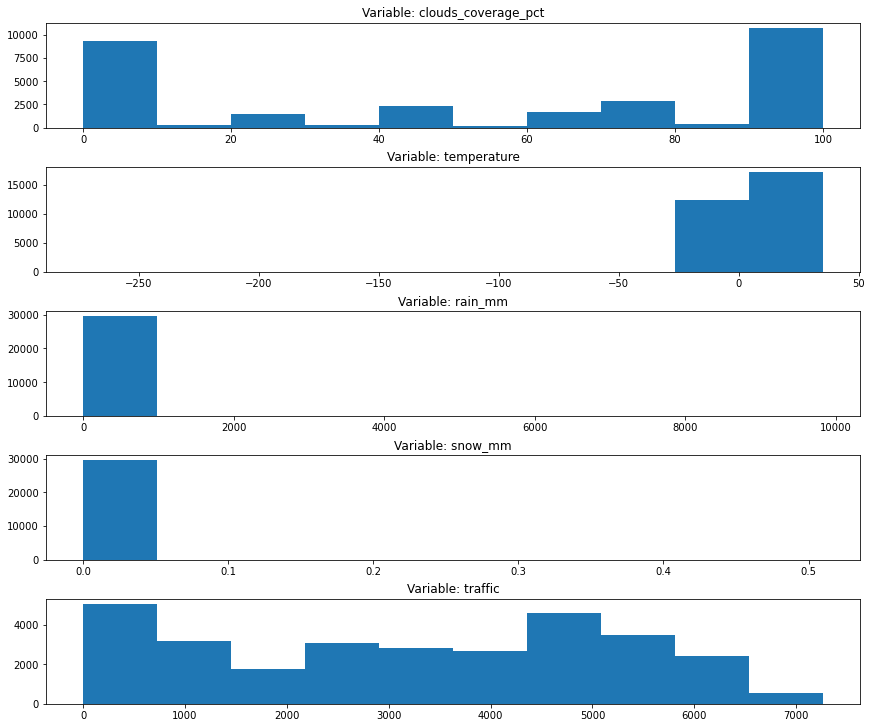

In [6]:
numericalVar = ['clouds_coverage_pct', 'temperature', 'rain_mm', 'snow_mm', 'traffic']
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(12, 10),
                        constrained_layout=True)
for idx, col in enumerate(numericalVar):
    axs[idx].hist(traffic[f'{col}'])
    axs[idx].set_title(f'Variable: {col}')
    


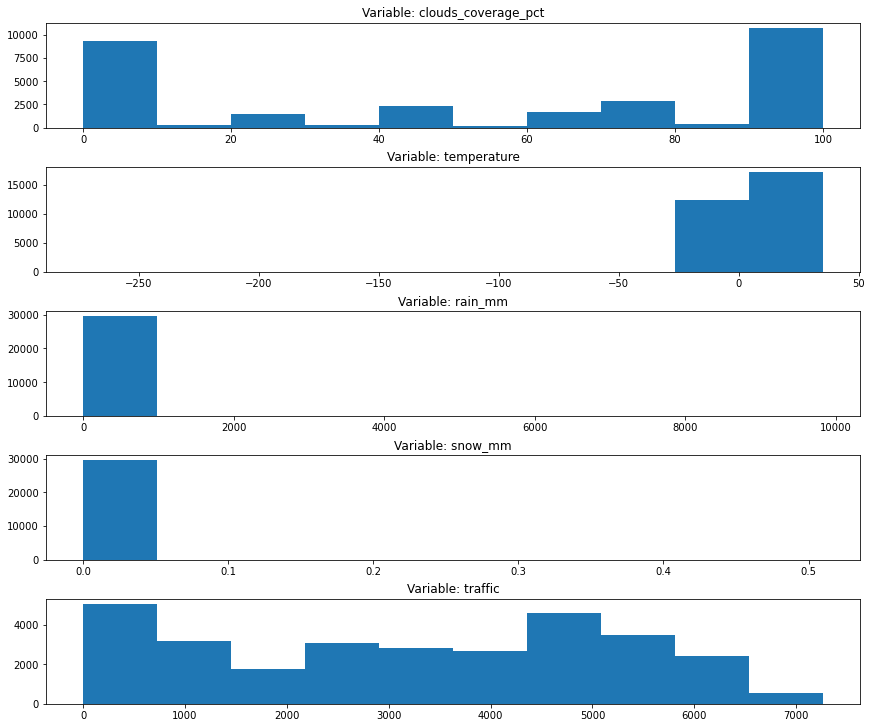

In [8]:
numericalVar = ['clouds_coverage_pct', 'temperature', 'rain_mm', 'snow_mm', 'traffic']
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(12, 10),
                        constrained_layout=True)
for idx, col in enumerate(numericalVar):
    axs[idx].hist(traffic[f'{col}'])
    axs[idx].set_title(f'Variable: {col}')

In [9]:
traffic

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,hour,hour_interval,day,month,tmp,ordinal_weather
0,2014-10-01 00:00:00,Clear,sky is clear,1,11.5,0.0,0.0,508,0,0-6,2,10,0,3
1,2014-10-01 01:00:00,Clear,sky is clear,1,10.3,0.0,0.0,323,1,0-6,2,10,1,3
2,2014-10-01 02:00:00,Clear,sky is clear,1,8.0,0.0,0.0,274,2,0-6,2,10,2,3
3,2014-10-01 03:00:00,Clear,sky is clear,1,7.9,0.0,0.0,372,3,0-6,2,10,3,3
4,2014-10-01 04:00:00,Clear,sky is clear,1,6.4,0.0,0.0,812,4,0-6,2,10,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29696,2018-12-31 22:00:00,Mist,mist,90,-0.2,0.0,0.0,1228,22,18-24,0,12,29696,1
29697,2018-12-31 22:00:00,Snow,light snow,90,-0.2,0.0,0.0,1218,22,18-24,0,12,29697,1
29698,2018-12-31 23:00:00,Mist,mist,90,-0.1,0.0,0.0,830,23,18-24,0,12,29698,1
29699,2018-12-31 23:00:00,Snow,light snow,90,-0.1,0.0,0.0,828,23,18-24,0,12,29699,1


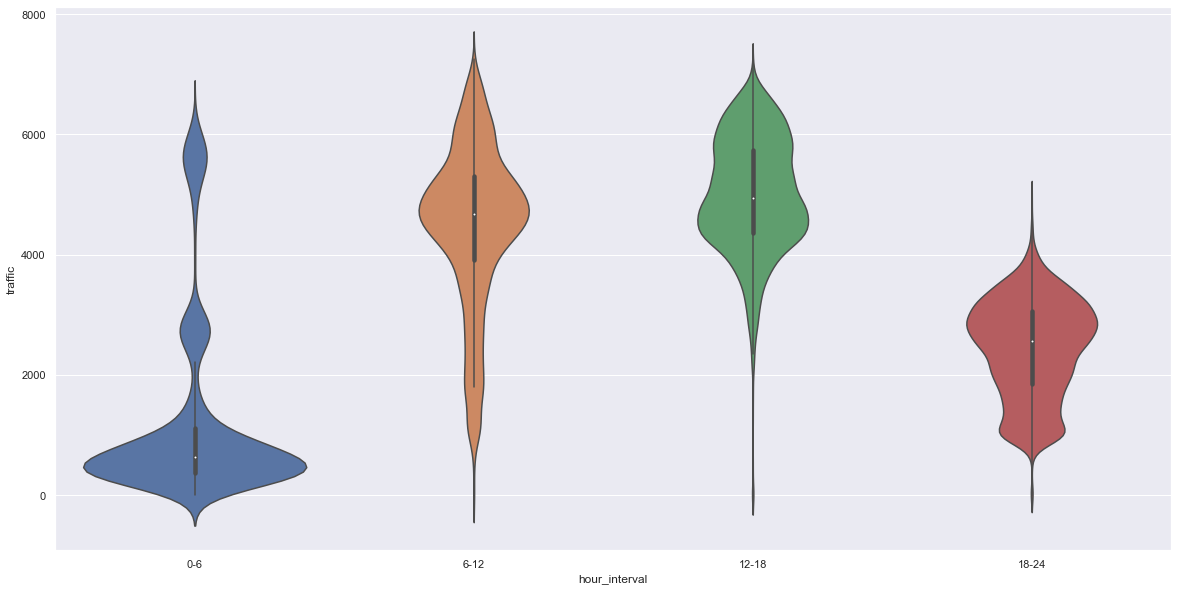

In [17]:
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.violinplot(x = traffic.hour_interval, y = traffic.traffic)

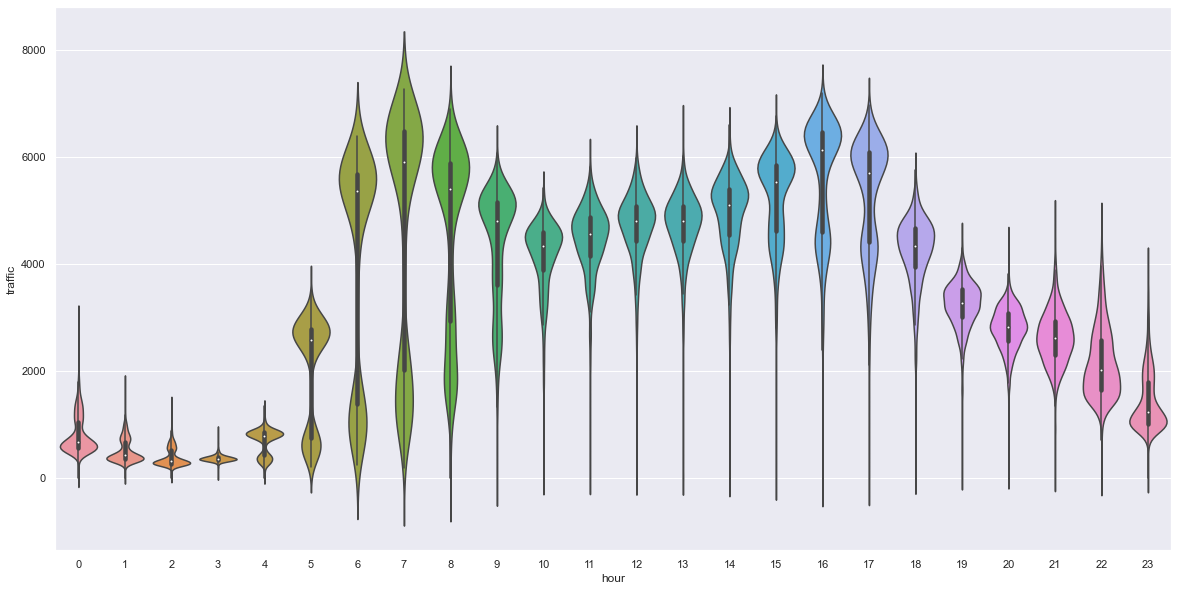

In [22]:
ax = sns.violinplot(x = traffic.hour, y = traffic.traffic, scale = "width")

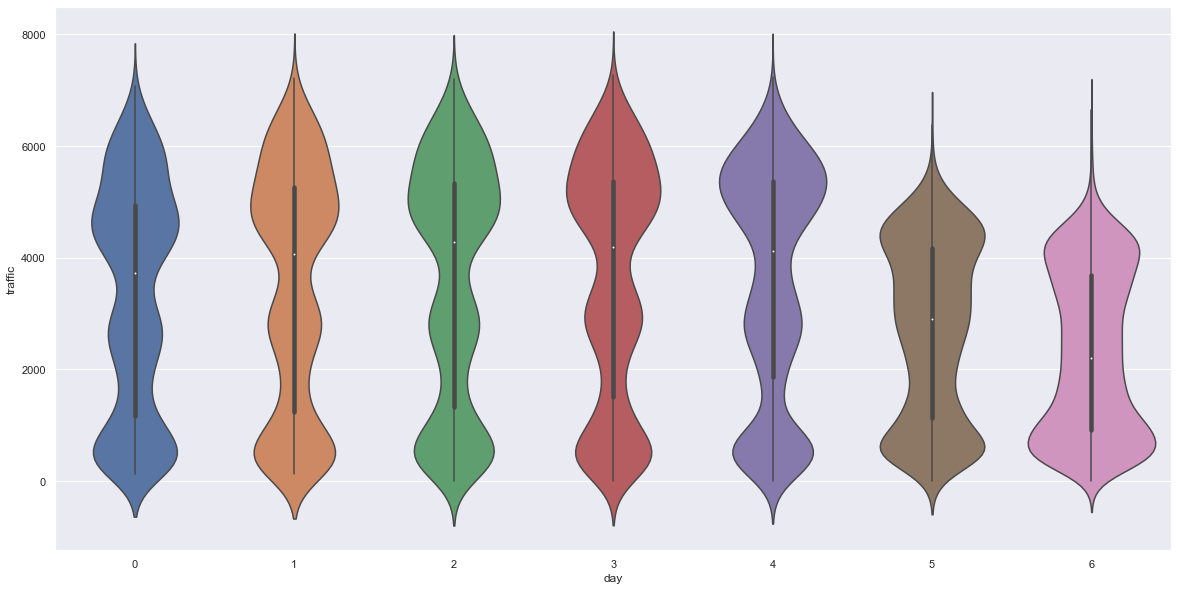

In [19]:
ax = sns.violinplot(x = traffic.day, y = traffic.traffic)

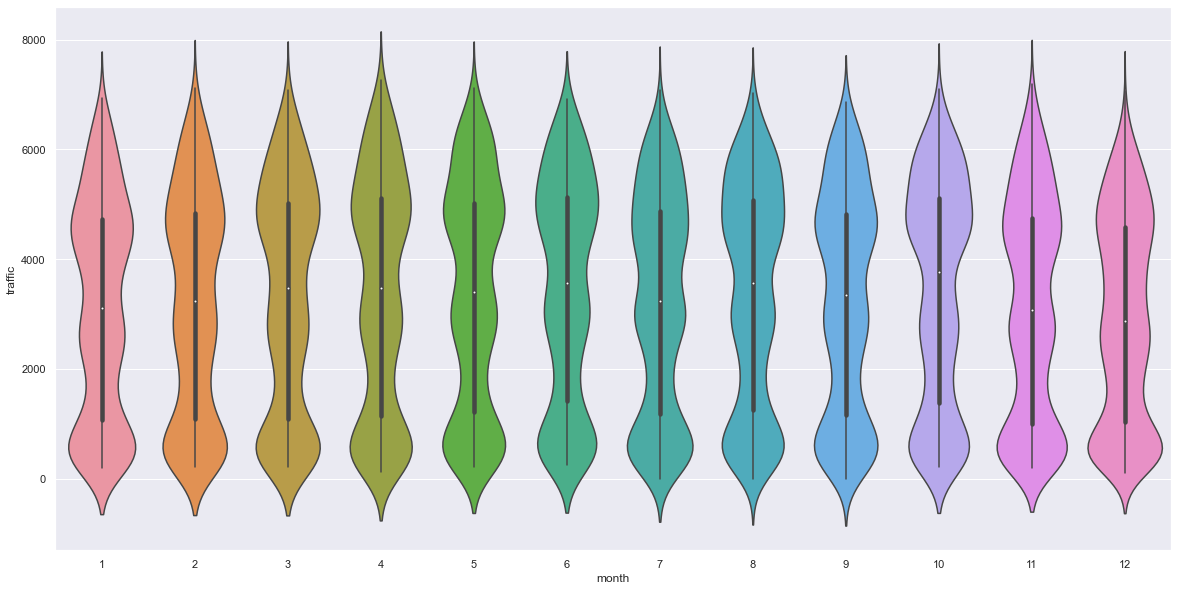

In [18]:
ax = sns.violinplot(x = traffic.month, y = traffic.traffic)

# 3. Standarize data

In [119]:
# scale = StandardScaler()

# numericalData = traffic[numericalVar]

# scaledData = scale.fit_transform(numericalData)
# traffic[numericalVar] = pd.DataFrame(scaledData)

# traffic

# 4. Corrplot

In [24]:
corr = traffic.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,hour,day,month,tmp,ordinal_weather
clouds_coverage_pct,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
temperature,-0.15,nan,nan,nan,nan,nan,nan,nan,nan,nan
rain_mm,0.01,0.01,nan,nan,nan,nan,nan,nan,nan,nan
snow_mm,0.04,-0.02,-0.00,nan,nan,nan,nan,nan,nan,nan
traffic,0.04,0.13,0.01,0.00,nan,nan,nan,nan,nan,nan
hour,0.02,0.11,0.00,0.01,0.35,nan,nan,nan,nan,nan
day,-0.02,-0.01,-0.01,-0.02,-0.16,-0.01,nan,nan,nan,nan
month,-0.02,0.13,0.00,0.02,-0.03,0.00,0.00,nan,nan,nan
tmp,-0.11,0.21,0.01,0.02,-0.02,-0.01,-0.01,0.15,nan,nan
ordinal_weather,-0.65,0.08,-0.02,-0.03,0.04,0.07,0.02,-0.02,0.04,nan


In [37]:
traffic = pd.read_csv('traffic_train.csv')
functions = [dayFromDate(traffic), ordinal_whether(traffic), weather_dummies(traffic), outliers_correction(traffic)]

traffic = dayFromDate(traffic)
traffic = ordinal_whether(traffic)
traffic = weather_dummies(traffic)
traffic = outliers_correction(traffic)

traffic = traffic[traffic['traffic'] != 0]
traffic = traffic[traffic['snow_mm'] == 0]
traffic = traffic[traffic['rain_mm'] == 0]
traffic = traffic.drop(columns = ['date_time', 'weather_general', 'weather_detailed', 'month', 'year', 'day', 'hour', 'rain_mm','snow_mm','hour_interval'])
#, '1_x',  '0-6','1_y','0_y'


x_train = traffic.drop(columns = ['traffic'])
y_train = traffic['traffic']

print(traffic.columns)
traffic.head()

Index(['clouds_coverage_pct',         'temperature',             'traffic',
           'ordinal_weather',                 '1_x',                 '2_x',
                       '3_x',                 '4_x',                 '5_x',
                       '6_x',                 '7_x',                 '8_x',
                       '9_x',                '10_x',                '11_x',
                      '12_x',                 '0-6',                '6-12',
                     '12-18',               '18-24',                 '0_x',
                       '1_y',                 '2_y',                 '3_y',
                       '4_y',                 '5_y',                 '6_y',
                       '7_y',                 '8_y',                 '9_y',
                      '10_y',                '11_y',                '12_y',
                          13,                    14,                    15,
                          16,                    17,                    18,
            

,clouds_coverage_pct,temperature,traffic,ordinal_weather,1_x,2_x,3_x,4_x,5_x,6_x,...,6,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Snow,Thunderstorm
0,1,11.5,508,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,10.3,323,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,8.0,274,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,7.9,372,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,6.4,812,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [45]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(x_train, y_train)

y_pred = lin_reg.predict(x_train)

print(mean_absolute_percentage_error(y_train, y_pred))
print(mean_absolute_error(y_train, y_pred))
print(r2_score(y_train, y_pred))
print(y_pred)
print(y_train)


0.7922372156907503
599.0644789224988
0.8302921982998935
[1236.  960.  810. ... 1228. 1170. 1240.]
0         508
1         323
2         274
3         372
4         812
         ... 
29696    1228
29697    1218
29698     830
29699     828
29700     824
Name: traffic, Length: 26877, dtype: int64


In [44]:
#
# from sklearn.tree import DecisionTreeRegressor

# tree_reg = DecisionTreeRegressor(random_state=42)
# tree_reg.fit(x_train, y_train)
# y_pred = tree_reg.predict(x_train)
# tree_mape = mean_absolute_percentage_error(y_train, y_pred)
# tree_mae = mean_absolute_error(y_train, y_pred)
# print(tree_mape, tree_mae)


0.003912022165397058 1.3600972330741279


In [24]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

pip_forest = Pipeline([("scaler", RobustScaler()),
                        ("classifier",RandomForestRegressor(random_state=997))])

param_grid = [
    {'classifier__n_estimators': [3, 10, 15, 20, 30], 'classifier__max_features': [2, 4, 6, 8,12]},
    {'classifier__bootstrap': [False], 'classifier__n_estimators': [3, 10, 15,20,25, 30], 'classifier__max_features': [2, 4, 6, 8,12]}
  ]


forest_reg = RandomForestRegressor(random_state=997)
# przeprowadza proces uczenia na pięciu podzbiorach, czyli łącznie (12+6)*5=90 przebiegów 
grid_search = GridSearchCV(pip_forest, param_grid, cv=10,
                           scoring='neg_mean_absolute_percentage_error',
                           return_train_score=True)
grid_search.fit(x_train, y_train)

best_forest = grid_search.best_estimator_ #RandomForestRegressor(bootstrap=False, max_features=3, n_estimators=3, random_state=42)
best_forest.fit(x_train, y_train)
y_forest = best_forest.predict(x_train)

print(mean_absolute_percentage_error(y_train, y_forest))
print(mean_absolute_error(y_train, y_forest))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('classifier',
                                        RandomForestRegressor(random_state=997))]),
             param_grid=[{'classifier__max_features': [2, 4, 6, 8, 12],
                          'classifier__n_estimators': [3, 10, 15, 20, 30]},
                         {'classifier__bootstrap': [False],
                          'classifier__max_features': [2, 4, 6, 8, 12],
                          'classifier__n_estimators': [3, 10, 15, 20, 25, 30]}],
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error')

In [43]:
best_forest = grid_search.best_estimator_ #RandomForestRegressor(bootstrap=False, max_features=3, n_estimators=3, random_state=42)
best_forest.fit(x_train, y_train)
y_forest = best_forest.predict(x_train)

print(mean_absolute_percentage_error(y_train, y_forest))
print(mean_absolute_error(y_train, y_forest))

0.19968030099735756
111.084647200858


In [39]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV

pip_elastic = Pipeline([("scaler", RobustScaler()),
                        ("classifier",ElasticNet(random_state=997))])

grid = dict()
grid['classifier__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['classifier__l1_ratio'] = np.arange(0, 1, 0.2)

# przeprowadza proces uczenia na pięciu podzbiorach, czyli łącznie (12+6)*5=90 przebiegów 
# ratios = arange(0, 1, 0.01)
# alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
grid_search = GridSearchCV(pip_elastic, grid, cv=5,
                           scoring='neg_mean_absolute_percentage_error',
                           return_train_score=True)
best_elastic = grid_search #RandomForestRegressor(bootstrap=False, max_features=3, n_estimators=3, random_state=42)
best_elastic.fit(x_train, y_train)

y_elastic = best_elastic.predict(x_train)

print(mean_absolute_percentage_error(y_train, y_elastic))
print(mean_absolute_error(y_train, y_elastic))

1.0847664415007903
597.5808420545562


In [48]:
from sklearn.linear_model import ElasticNet
x = ElasticNet(alpha= 0, l1_ratio = 0.0).fit(x_train, y_train)
y_elastic = x.predict(x_train)

print(mean_absolute_percentage_error(y_train, y_elastic))
print(mean_absolute_error(y_train, y_elastic))

0.7917531065323606
598.6441989107556


In [49]:
from sklearn.svm import SVR
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

regressor = SVR(kernel = 'sigmoid')
regressor.fit(x_train, y_train)

svn_pred = regressor.predict(x_train)


print(mean_absolute_percentage_error(y_train, svn_pred))
print(mean_absolute_error(y_train, svn_pred))


2.4495156857767375
1725.8358453943422


In [41]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 20)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(x_train, y_train)
# knn_model = KNeighborsRegressor(n_neighbors=3)
# knn_model.fit(x_train, y_train)
knn_predicted = gridsearch.predict(x_train)

print(mean_absolute_percentage_error(y_train, knn_predicted))
print(mean_absolute_error(y_train, knn_predicted))

0.6713272156709597
530.4205752130074


In [51]:
knn_predicted = KNeighborsRegressor(n_neighbors=60).fit(x_train,y_train).predict(x_train)

print(mean_absolute_percentage_error(y_train, knn_predicted))
print(mean_absolute_error(y_train, knn_predicted))

1.4609459170368024
1066.347288883928


In [55]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.1)
reg.fit(x_train, y_train)
y_reg = reg.predict(x_train)


print(mean_absolute_percentage_error(y_train, y_reg))
print(mean_absolute_error(y_train, y_reg))


0.7918619992809433
598.7774947457829


In [54]:
from sklearn.linear_model import TweedieRegressor
reg = TweedieRegressor(power=1, alpha=0.1, link='log')
reg.fit(x_train, y_train)
y_reg = reg.predict(x_train)


print(mean_absolute_percentage_error(y_train, y_reg))
print(mean_absolute_error(y_train, y_reg))



0.6961264249333717
541.7459186959372


1.8595867926552383
456.7360454630021


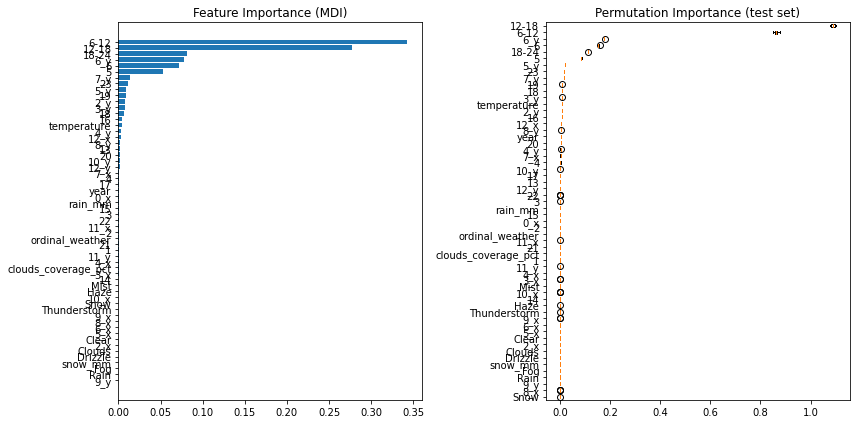

In [143]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

y_reg = reg.predict(x_train)


print(mean_absolute_percentage_error(y_train, y_reg))
print(mean_absolute_error(y_train, y_reg))
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(x_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, x_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(x_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

0.08168717384098441
67.22208806778993


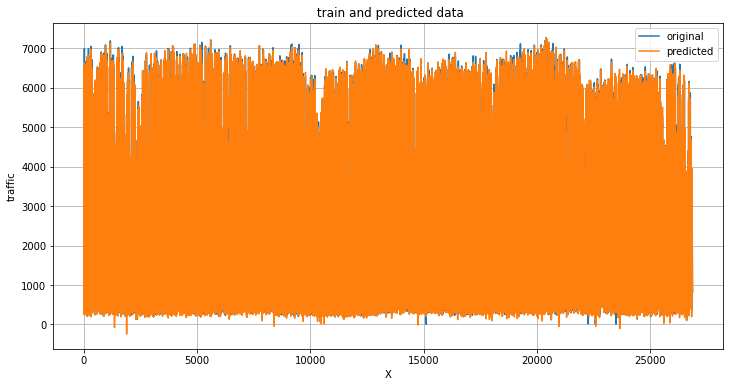

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

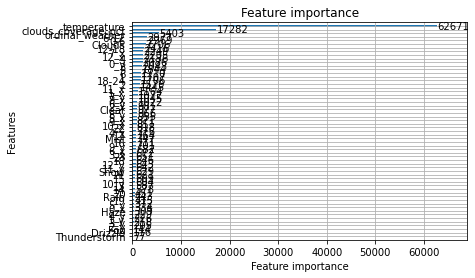

In [64]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'n_estimators': 900,
    'learning_rate': 0.3,
    'objective': 'regression',
    'num_leaves': 4096,
    'max_depth' : 12,
    'metric': {'l2','l1'},
    'verbose': -1
}

lgb_train = lgb.Dataset(x_train, y_train)


model = lgb.train(params,
                 train_set=lgb_train)
                 #valid_sets=y_train,
                 #early_stopping_rounds=30)


lgm_pred = model.predict(x_train)


print(mean_absolute_percentage_error(y_train, lgm_pred))
print(mean_absolute_error(y_train, lgm_pred))

x_ax = range(len(y_train))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_train, label="original")
plt.plot(x_ax, lgm_pred, label="predicted")
plt.title(" train and predicted data")
plt.xlabel('X')
plt.ylabel('traffic')
plt.legend(loc='best',fancybox=True, shadow=False)
plt.grid(True)
plt.show()  

lgb.plot_importance(model, height=.5)
